In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from datamodule import WikipediaDataModule
from model import AbstractModel, CoordinateAscentModel
from utils import get_profile_embeddings_by_model_key

import argparse
import collections
import glob
import json
import os
import re

import datasets
import pandas as pd
import torch
import transformers
from tqdm import tqdm


from model_cfg import model_paths_dict

datasets.utils.logging.set_verbosity_error()

num_cpus = len(os.sched_getaffinity(0))

def get_profile_embeddings(model_key: str):
    profile_embeddings = get_profile_embeddings_by_model_key(model_key=model_key)

    print("concatenating train, val, and test profile embeddings")
    all_profile_embeddings = torch.cat(
        (profile_embeddings['test'], profile_embeddings['val'], profile_embeddings['train']), dim=0
    )

    print("all_profile_embeddings:", all_profile_embeddings.shape)
    return all_profile_embeddings

def load_adv_csv(dm: WikipediaDataModule, max_num_samples: int = 100) -> pd.DataFrame:
    # Load adv CSVs
    adv_df = None
    adv_csvs_folder = os.path.normpath(
        os.path.join(
            os.getcwd(), os.pardir, 'adv_csvs_full_8'
        )
    )
    print('adv_csvs_folder', adv_csvs_folder)
    model_csv_filenames = list(glob.glob(
        os.path.join(
            adv_csvs_folder,
            'model*/results*.csv'
        )
    ) )
    print("len(model_csv_filenames) =", len(model_csv_filenames))
    for filename in (model_csv_filenames):
        # print('filename:', filename)
        df = pd.read_csv(filename)
        
        if len(df) < 1000: continue
        
        df = df[(df['result_type'] == 'Successful') | (df['result_type'] == 'Skipped')]
        json_filename = filename.replace('.csv', '__args.json')
        assert os.path.exists(json_filename)
        
        adv_csv_json = json.load(open(json_filename, 'r'))
        
        ##### Only take results that are IDF ("nomodel") or from chosen hparam values. ######
        if not (('nomodel' in filename) or (
            (adv_csv_json["table_score"] == 0.1)
            and
            (adv_csv_json["min_percent_words"] == 0.4)
            and
            (adv_csv_json["min_idf_weighting"] == 1.0)
        )):
            continue
        
        df["filename"] = filename
        for key, val in adv_csv_json.items():
            df[key] = val
        df["i"] = df.index
        
        df = df.rename(columns={"model": "model_name"})

        mini_df = df.iloc[:max_num_samples]

        if adv_df is None:
            adv_df = mini_df
        else:
            adv_df = pd.concat((adv_df, mini_df), axis=0)
        # print(adv_df)
    
    print("loaded adv_df of length", len(adv_df))
    # Load baseline redacted data
    mini_test_dataset = dm.test_dataset[:max_num_samples]
    doc_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document']
    )
    doc_df['model_name'] = 'document'
    doc_df['i'] = doc_df.index
    doc_df['filename'] = 'document'
    
    ner_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_ner_bert']
    )
    ner_df['model_name'] = 'named_entity'
    ner_df['i'] = ner_df.index
    ner_df['filename'] = 'named_entity'
        
    lex_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_lexical']
    )
    lex_df['model_name'] = 'lexical'
    lex_df['i'] = lex_df.index
    lex_df = lex_df.iloc[:max_num_samples]
    lex_df['filename'] = 'lexical'

    # Combine both adversarial and baseline redacted data
    baseline_df = pd.concat((doc_df, lex_df, ner_df), axis=0)
    for key in adv_csv_json.keys():
        if key not in baseline_df: baseline_df[key] = None
        
    
    full_df = pd.concat((adv_df, baseline_df), axis=0)
    
    # Put newlines back
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<SPLIT>', '\n'))

    # Standardize mask tokens
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('[MASK]', dm.mask_token))
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<mask>', dm.mask_token))
    
    # Fair truncation
    full_df['original_num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    for i in full_df['i'].unique():
        #         df.loc[df.loc[df['a'] == 1,'b'].index[1], 'b'] = 3
        min_num_words = full_df[full_df['i'] == i]['original_num_words'].min()
        full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'] = (
            full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'].map(
                lambda t: ' '.join(t.split()[:min_num_words])
            )
        )
    
    full_df['num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    
    
    # This makes sure sure all documents with a given index have the same number of words.
    assert full_df.groupby('i')['num_words'].std().max() == 0.0

    return full_df


def get_adv_predictions(model_key: str, max_num_samples: int):
    checkpoint_path = model_paths_dict[model_key]
    assert isinstance(checkpoint_path, str), f"invalid checkpoint_path {checkpoint_path} for {model_key}"
    print(f"running eval on {model_key} loaded from {checkpoint_path}")
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )

    print(f"loading data with {num_cpus} CPUs")
    dm = WikipediaDataModule(
        document_model_name_or_path=model.document_model_name_or_path,
        profile_model_name_or_path=model.profile_model_name_or_path,
        dataset_name='wiki_bio',
        dataset_train_split='train[:256]',
        dataset_val_split='val[:256]',
        dataset_test_split='test[:100%]',
        dataset_version='1.2.0',
        num_workers=num_cpus,
        train_batch_size=256,
        eval_batch_size=256,
        max_seq_length=128,
        sample_spans=False,
    )
    dm.setup("fit")

    adv_csv = load_adv_csv(dm=dm, max_num_samples=max_num_samples)

    all_profile_embeddings = get_profile_embeddings(model_key=model_key).cuda()

    model.document_model.eval()
    model.document_model.cuda()
    model.document_embed.eval()
    model.document_embed.cuda()

    topk_values = []
    topk_idxs = []
    true_profile_idxs = []
    batch_size = 256
    i = 0
    pbar = tqdm(total=len(adv_csv), leave=False, desc='Making predictions...')
    while i < len(adv_csv):
        ex = adv_csv.iloc[i:i+batch_size]
        test_batch = dm.document_tokenizer.batch_encode_plus(
            ex['perturbed_text'].tolist(),
            max_length=dm.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        test_batch = {
            f'perturbed_text__{k}': v for k,v in test_batch.items()
        }
        correct_idxs = torch.tensor(ex['i'].tolist()).cuda()
        with torch.no_grad():
            document_embeddings = model.forward_document(batch=test_batch, document_type='perturbed_text')
            document_to_profile_logits = document_embeddings @ all_profile_embeddings.T
            document_to_profile_probs = document_to_profile_logits.softmax(dim=1)
            topk_10 = document_to_profile_probs.topk(10)
            topk_values.append(topk_10.values)
            topk_idxs.append(topk_10.indices)
            
            batch_true_profile_idxs = (
                (document_to_profile_logits.argsort(dim=1).flip(1) == correct_idxs[:, None]).nonzero()[:, 1]
            )
            true_profile_idxs.append(batch_true_profile_idxs)

        i += batch_size
        pbar.update(batch_size)
    
    adv_csv['pred_topk_values'] = torch.cat(topk_values, dim=0).cpu().tolist()
    adv_csv['pred_topk_idxs'] = torch.cat(topk_idxs, dim=0).cpu().tolist()
    adv_csv['true_profile_idxs'] = torch.cat(true_profile_idxs, dim=0).cpu().tolist()
    
    
    model.document_model.cpu()
    model.document_embed.cpu()
    model.cpu()
    return adv_csv



In [2]:
################################ testing code for loading csvs ################################
###   dm = WikipediaDataModule(
###       document_model_name_or_path='roberta-base',
###       profile_model_name_or_path='google/tapas-base',
###       dataset_name='wiki_bio',
###       dataset_train_split='train[:256]',
###       dataset_val_split='val[:256]',
###       dataset_test_split='test[:100%]',
###       dataset_version='1.2.0',
###       num_workers=num_cpus,
###       train_batch_size=256,
###       eval_batch_size=256,
###       max_seq_length=128,
###       sample_spans=False,
###   )
###   dm.setup("fit")
###   adv_csv = load_adv_csv(dm=dm, max_num_samples=100)
################################################################################################

In [3]:
n = 1000

# pmlm_tapas_lex_predictions = get_adv_predictions(model_key='model_3_5__epoch47', max_num_samples=n)
pmlm_tapas_predictions = get_adv_predictions(model_key='model_3_4', max_num_samples=n)
roberta_tapas_predictions = get_adv_predictions(model_key='model_3_2', max_num_samples=n)
roberta_roberta_predictions = get_adv_predictions(model_key='model_3_3', max_num_samples=n)
# TODO: drop predictions if we predicted the same thing with same hparams just different values of n. Like
# if we have filenames with n=1000 and n=100. Just take the one with largest n.

running eval on model_3_4 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__pmlm-a__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_default/1g8o1iw3_749/checkpoints/epoch=65-step=150281-idf_total.ckpt
Initialized model with learning_rate = 5e-05 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `[MASK]`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 120
loaded adv_df of length 58739
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/val

running eval on model_3_2 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/ojgxa1tf_6/checkpoints/epoch=65-step=150282-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 120
loaded adv_df of length 58739
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 307

running eval on model_3_3 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/2cr1gp87_28/checkpoints/epoch=68-step=157113.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaMod

Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 120
loaded adv_df of length 58739
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 307

In [378]:
from typing import List

new_model_name = {
    'model_3_1': 'roberta_tapas__no_masking',
    'model_3_2': 'roberta_tapas',
    'model_3_3': 'roberta_roberta',
    'model_3_4': 'pmlm_tapas',
    'model_3_5__epoch47': 'pmlm_tapas_lex',
}

preds_by_model_name = {
    # 'roberta_tapas__no_masking': None,
    'roberta_tapas': roberta_tapas_predictions,
    'roberta_roberta': roberta_roberta_predictions,
    'pmlm_tapas': pmlm_tapas_predictions,
    # 'bm25': bm25_predictions,
    # 'pmlm_tapas_lex': pmlm_tapas_lex_predictions,
}

##############################################################################################################

out_df = pmlm_tapas_predictions.rename(
    columns={
        'pred_topk_values': 'pmlm_tapas_pred_topk_values', 
        'pred_topk_idxs': 'pmlm_tapas__pred_topk_idxs',
        'true_profile_idxs': 'pmlm_tapas__true_profile_idxs',
    }
)
out_df['model_name'] = out_df['model_name'].apply(lambda s: new_model_name.get(s, s))

# Only take predictions from the first files outputted. Sometimes they change in-between
# so some dataframes have more than others.
shared_filenames = pmlm_tapas_predictions['filename'].unique()

for model_name, model_df in preds_by_model_name.items():
    print(model_name)
    model_df['was_correct'] = (
        model_df['pred_topk_idxs'].map(lambda L: L[0] if len(L) else None) == model_df['i']
    )
    # Makes sure all the files in this df were in the first one we loaded too. Prevents weird
    # issues where a file pops up in-between loading predictions from different models and we have 
    # dataframes of different lengths.
    model_df_smaller = model_df[model_df['filename'].map(lambda s: s in shared_filenames)].reset_index()
    out_df[f'{model_name}__was_correct'] = (
        # TODO: figure out why we need tolist() here.
        model_df_smaller['was_correct'].tolist()
    )
    print(f'{model_name}__was_correct', out_df[f'{model_name}__was_correct'].mean())
    out_df[f'{model_name}__topk_idxs'] = model_df_smaller['pred_topk_idxs'].tolist()
    out_df[f'{model_name}__topk_values'] = model_df_smaller['pred_topk_values'].tolist()
    if 'true_profile_idxs' in model_df_smaller.columns: out_df[f'{model_name}__true_profile_idxs'] = model_df_smaller['true_profile_idxs'].tolist()
    
out_df['any_model__was_correct'] = (
    out_df['roberta_roberta__was_correct'] | 
    out_df['roberta_tapas__was_correct'] | 
    out_df['pmlm_tapas__was_correct']
    # | out_df['pmlm_tapas_lex__was_correct']
)



words_from_text_re = re.compile(r'\b\w+\b')
def words_from_text(s: str) -> List[str]:
    assert isinstance(s, str)
    return words_from_text_re.findall(s)

num_words_from_text = lambda s: len(words_from_text(s))


out_df['num_words'] = out_df['perturbed_text'].map(num_words_from_text)

out_df['perturbed_text'] = out_df['perturbed_text'].map(lambda s: s.replace('[MASK]', '<mask>'))
out_df['num_masks'] = out_df['perturbed_text'].map(lambda s: s.count('<mask>'))

out_df["percent_masks"] = out_df["num_masks"] / out_df["num_words"]
out_df["percent_not_masks"] = 1.0 - out_df["percent_masks"]


out_df["deidentified"] = (~out_df["any_model__was_correct"]) | (out_df["percent_masks"] >= 0.7)
out_df["reidentified"] = ~out_df["deidentified"]

out_df = out_df.drop(columns=['level_0', 'index', 'Unnamed: 0'], errors='ignore')
out_df.head()

roberta_tapas
roberta_tapas__was_correct 0.30539853253211097
roberta_roberta
roberta_roberta__was_correct 0.3546542703963459
pmlm_tapas
pmlm_tapas__was_correct 0.27877030726121255


,original_person,original_text,perturbed_person,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,...,roberta_roberta__true_profile_idxs,pmlm_tapas__was_correct,pmlm_tapas__topk_idxs,pmlm_tapas__topk_values,any_model__was_correct,num_masks,percent_masks,percent_not_masks,deidentified,reidentified
0,Lenny randle,"leonard shenoff randle ( born february 12 , 19...",Lenny randle,"<mask> <mask> <mask> ( <mask> <mask> <mask> , ...",-1.0,0.048638,0.0,0.0,0.0,663.0,...,48412,False,"[213899, 450117, 562361, 459299, 653052, 25746...","[0.032093536108732224, 0.008493590168654919, 0...",False,31,0.815789,0.184211,True,False
1,Lenny randle,philippe adnot ( born 25 august 1945 in rhèges...,Lenny randle,<mask> <mask> ( <mask> <mask> <mask> <mask> in...,-1.0,0.048638,0.0,0.0,1.0,3398.0,...,206,False,"[253427, 583055, 140849, 555483, 100301, 69467...","[0.003854961832985282, 0.0031959153711795807, ...",False,77,0.777778,0.222222,True,False
2,Lenny randle,miroslav popov ( born 14 june 1995 in dvůr krá...,Lenny randle,<mask> <mask> ( <mask> <mask> <mask> <mask> in...,-1.0,0.048638,0.0,0.0,2.0,616.0,...,73,False,"[557846, 399336, 460879, 300650, 16985, 218387...","[0.042731475085020065, 0.02043233998119831, 0....",False,30,0.857143,0.142857,True,False
3,Lenny randle,john `` jack '' reynolds ( 21 february 1869 --...,Lenny randle,<mask> `` <mask> '' <mask> ( <mask> <mask> <ma...,-1.0,0.048638,0.0,0.0,3.0,2477.0,...,504,False,"[417613, 318094, 185910, 708432, 517476, 36241...","[0.0293087437748909, 0.020047971978783607, 0.0...",False,69,0.884615,0.115385,True,False
4,Lenny randle,"william ato ankrah , ( born 7th july 1979 ) be...",Lenny randle,"<mask> <mask> <mask> , ( <mask> <mask> <mask> ...",-1.0,0.048638,0.0,0.0,4.0,846.0,...,101567,False,"[697077, 541741, 350222, 498841, 64669, 215915...","[0.011341960169374943, 0.006159963086247444, 0...",False,38,0.904762,0.095238,True,False


In [429]:
out_df['perturbed_text'].iloc[0]

'<mask> <mask> <mask> ( <mask> <mask> <mask> , <mask> ) <mask> a <mask> <mask> <mask> <mask> <mask> . <mask> <mask> the <mask>-<mask> <mask> of the <mask> <mask> <mask> the <mask> <mask> of the <mask> <mask> <mask> <mask> <mask> <mask> , <mask> <mask> .'

In [430]:

words_from_text_mask_re = re.compile(r'[~\<\>\w][\<\>\w]+[~\<\>\w]')
def words_from_text_mask(s: str) -> List[str]:
    assert isinstance(s, str)
    return words_from_text_re.findall(s)


words_from_text_mask(out_df['perturbed_text'].iloc[0])

['mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'a',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'the',
 'mask',
 'mask',
 'mask',
 'of',
 'the',
 'mask',
 'mask',
 'mask',
 'the',
 'mask',
 'mask',
 'of',
 'the',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [379]:
out_df[(out_df['filename'] == 'document')]['roberta_roberta__was_correct'].mean()

0.991

In [380]:
import seaborn as sns

sns.set()
sns.set_theme(context="paper", style="white")

In [381]:
from typing import Any, Dict


fix_group_name = {
    "lexical": "Lexical", 
    "named_entity": "Named Entity",
    "document": "Document",
}

def get_group_name(row: Dict[str, Any]) -> str:
    filename = row['filename']
    if filename in ['document', 'lexical', 'named_entity']:
        return fix_group_name[filename]
    elif "nomodel" in filename:
        if "_ts100.0_" in filename:
            return "IDF (table-aware)"
        else:
            return "IDF"
    else:
        return "NN DeID"
        # return f"ts_{row['table_score']:.2f}__mpw{row['min_percent_words']:.2f}__min_idf{row['min_idf_weighting']:.2f}"
    out_df["group_name"] = out_df.apply(get_group_name, axis=1)
    

# have to fill NaNs with 0.0 so we can keep those columns. this also drops results from some other experiments that i had b=2.
df_grouped = out_df.fillna(0.0)[out_df.fillna(0.0)["beam_width"] <= 1].groupby("filename").mean().reset_index()


print("% masks:", df_grouped["percent_masks"].mean())
    
df_grouped["group_name"] = df_grouped.apply(lambda row: get_group_name(row), axis=1)
# df_grouped["filename_short"] = df_grouped["filename"].map(lambda s: s[s.rindex('/')+1:s.rindex('.csv')] if '.csv' in s else s) # TODO renamee
# df_grouped["model_name__k"] = df_grouped["model_name"] + df_grouped["k"].map(lambda k: f'__{k}')

# https://matplotlib.org/stable/api/markers_api.html
marker_by_model_name = {
    "Lexical": "s", #"X",
    "Named Entity": "s", # "X",
    "Document": "s"
}
df_grouped["marker"] = df_grouped.apply(lambda row: marker_by_model_name.get(row["group_name"], "o"), axis=1)


# Manually ordering names because this is how they will eventually show up in the legend
ordered_group_names = [
    'NN DeID',  'IDF',  'IDF (table-aware)', 
    'Document', 
    'Lexical',
    'Named Entity'
]

num_filenames = len(df_grouped["group_name"].unique())
color_by_model_name = dict(
    zip(ordered_group_names, sns.color_palette("hls", num_filenames))
)
df_grouped["color"] = df_grouped["group_name"].apply(color_by_model_name.get)

% masks: 0.36873070796364255


In [437]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

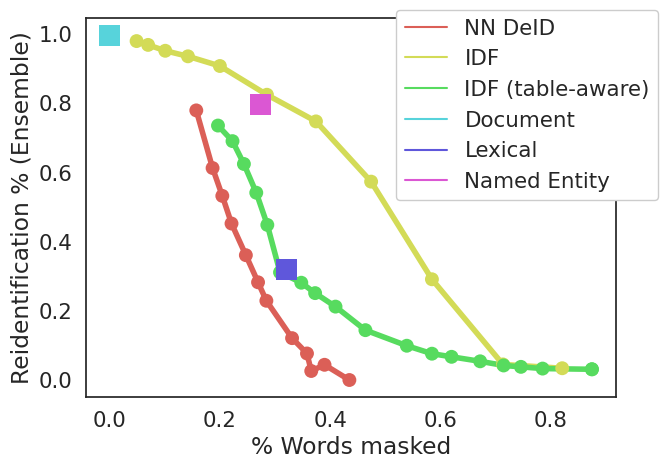

In [458]:
import matplotlib

def make_reid_plot(reid_model_name: str, x_column: str, y_column: str, xlabel: str, ylabel: str, marker_size: int = 110, set_lim=True):
    # sns.set_theme(context="paper", style="white")
    sns.set(style="white", font_scale = 1.4)
    plt.figure(figsize=(7,5))
    font_size = 21
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    group_key = "group_name"
    
    # df_grouped_filtered = df_grouped
    df_grouped_filtered = df_grouped[
        df_grouped[group_key].apply(lambda row_model_name: (reid_model_name not in row_model_name))
    ]
    
    
    def should_we_keep_this_line(row: str) -> bool:
        group_name = row["group_name"]
        if group_name.startswith("NN"):
            # filter out most points since we have way too many data points too close together
            eps_values_for_graph = [
                1e-08, 1e-07, 1e-06, 1e-4, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.7
            ]
            eps = row["eps"]
            return eps in eps_values_for_graph
        elif group_name == "IDF":
            # filter out top point
            return row["max_idf_goal"] < 11
        elif group_name == "IDF (table-aware)":
            # filter out runs that had min percent words of less than 0.5
            # because they make IDF look unnecessarily bad when aggregated.
            mpw = row["min_percent_words"]
            # if mpw >= 0.5: print(row["max_idf_goal"], f'{row["min_percent_words"]:.2f}', f'{row["percent_masks"]:.2f}', f'{row["any_model__was_correct"]:.2f}')
            return (mpw >= 0.5) and ((row["max_idf_goal"] == 11.0) or (row["max_idf_goal"] <= 8))
        else:
            return True
    
    df_grouped_filtered = df_grouped[df_grouped.apply(should_we_keep_this_line, axis=1)].reset_index()
    df_grouped_filtered["group_name"] = df_grouped_filtered["group_name"].map(lambda g: fix_group_name.get(g,g))
    
    g1 = sns.lineplot(
        data=df_grouped_filtered,
        x=x_column,
        y=y_column,
        hue=group_key,
        palette=color_by_model_name,
        linewidth=4,
        legend=True
    )
    # plt.setp(g1.lines, zorder=100)
    # g1.set_xscale('log')
    # g1.legend(loc='upper right', label_order=[1,0,2,3,4,5])
    if set_lim: g1.set(xlim=(.18,.8), ylim=(-0.05, 0.45))
    
    # hacky line of code to make sure the squares are plotted at the end, and therefore show up after everything else
    for marker_type, marker_size in [('o', 100), ('s', 150)]:
        df_grouped_marker = df_grouped_filtered[
            df_grouped_filtered["marker"] == marker_type
        ]
        g2 = sns.scatterplot(
            data=df_grouped_marker,
            x=x_column,
            y=y_column,
            hue=group_key,
            palette=color_by_model_name,
            s=(marker_size if marker_type == 'o' else marker_size*1.5),
            marker=marker_type,
            linewidth=0.0,
            legend=False
        )
        
        if marker_type == 's':
            plt.setp(g2.lines, zorder=100)
            plt.setp(g2.collections, zorder=100, label="")
        # g2.set_xscale('log')
    if set_lim: g2.set(xlim=(.18,.8), ylim=(-0.05, 0.45))
    
    # plt.setp(g1.get_legend().get_texts(), fontsize=font_size) '
    order = [1, 0, 2, 3, 4, 5]
    handles, labels = plt.gca().get_legend_handles_labels()
    
    plt.legend([handles[i] for i in order], [labels[i] for i in order], bbox_to_anchor=(1.1, 1.05), framealpha=1.0)
    plt.tight_layout()


# make_reid_plot(reid_model_name="roberta_roberta", x_column="percent_masks",     y_column = "roberta_roberta__was_correct", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="% Words masked", set_lim=False)
make_reid_plot(reid_model_name="any_model", x_column="percent_masks", y_column="any_model__was_correct", ylabel="Reidentification % (Ensemble)", xlabel="% Words masked", set_lim=False)
plt.savefig("pareto_curve.pdf", dpi=300)

## outputting data for analysis

In [383]:
important_filenames = [
    # IDF-weighted, 29.7% masked, 25.1% reidentifiable
    '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig7.0__epsNone__k_0__n_1000__type_swap.csv',
    # Deidentified by our model, 23. masked, 12% re-identifiable
    '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.1__idf1.0__mp0.4__eps0.001__k_None__n_1000__type_swap.csv',
    # documents: 0% masked, 99.6% identifiable
     'document',
    # lexically-redacted: 24.5% masked, 31.9% identifiable
     'lexical',
    # named-entity-redacted: 22.2% masked, 79.7% identifiable
     'named_entity',
]

In [403]:
out_df.groupby('filename').mean()['percent_masks']

filename
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.0__nomodel__idf0.0__mig0.75__epsNone__k_0__n_1000__type_swap.csv            0.821566
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.0__nomodel__idf0.0__mig1.5__epsNone__k_0__n_1000__type_swap.csv             0.713931
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.0__nomodel__idf0.0__mig10.0__epsNone__k_0__n_1000__type_swap.csv            0.048559
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.0__nomodel__idf0.0__mig11.0__epsNone__k_0__n_1000__type_swap.csv            0.033602
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.0__nomodel__idf0.0__mig12.0__epsNone__k_0__n_1000__type_swap.csv            0.022634
           

In [384]:
out_df["group_name"] = df_grouped.apply(lambda row: get_group_name(row), axis=1)

In [385]:
keep_columns = [
    'perturbed_text',
    'num_queries',
    'num_words', 'i',

    'pmlm_tapas__was_correct', 'pmlm_tapas__topk_idxs',
    'pmlm_tapas__topk_values',  'pmlm_tapas__true_profile_idxs',
    
    'roberta_tapas__was_correct', 'roberta_tapas__topk_idxs',
    'roberta_tapas__topk_values', 'roberta_tapas__true_profile_idxs',
    
    'roberta_roberta__was_correct', 'roberta_roberta__topk_idxs',
    'roberta_roberta__topk_values', 'roberta_roberta__true_profile_idxs',

    'any_model__was_correct', 'num_masks',
    'group_name'
]
analysis_df = out_df[out_df["filename"].map(lambda s: s in important_filenames)][keep_columns]
analysis_df["group_name"] = analysis_df["group_name"].replace({"ts_1.0__mpw0.95__min_idf1.0": "pmlm_tapas__eps_0.0005", "IDF": "idf__maxidf_7.0"})
final_analysis_df = analysis_df.rename(columns={"group_name": "deid_method"})

final_analysis_df.to_parquet('../wikibio_redacted_3.parquet.gzip', compression='gzip')

In [386]:
final_analysis_df["deid_method"].value_counts()


IDF (table-aware)    160
NN DeID               89
idf__maxidf_7.0       62
Lexical                5
Document               4
Named Entity           4
Name: deid_method, dtype: int64

In [388]:
final_analysis_df[final_analysis_df['deid_method'] == 'Lexical']

,perturbed_text,num_queries,num_words,i,pmlm_tapas__was_correct,pmlm_tapas__topk_idxs,pmlm_tapas__topk_values,pmlm_tapas__true_profile_idxs,roberta_tapas__was_correct,roberta_tapas__topk_idxs,roberta_tapas__topk_values,roberta_tapas__true_profile_idxs,roberta_roberta__was_correct,roberta_roberta__topk_idxs,roberta_roberta__topk_values,roberta_roberta__true_profile_idxs,any_model__was_correct,num_masks,deid_method
67,<mask> <mask> is a retired jamaican <mask> pla...,1256.0,94,67,False,"[635635, 186002, 257990, 67, 652433, 419283, 3...","[0.17786885797977448, 0.13523203134536743, 0.0...",3,False,"[186002, 712555, 611594, 447817, 92292, 138522...","[0.2975841462612152, 0.08169902116060257, 0.05...",14,False,"[186002, 712555, 352828, 76255, 386188, 79214,...","[0.22906243801116943, 0.05531223490834236, 0.0...",6307,False,29,Lexical
67,<mask> <mask> is a retired <mask> soccer playe...,233.0,94,67,False,"[706772, 656847, 143720, 404958, 574054, 44603...","[0.09386694431304932, 0.05407393351197243, 0.0...",875,False,"[79005, 632413, 283470, 110516, 300907, 91725,...","[0.043542735278606415, 0.03995827957987785, 0....",1098,False,"[503902, 49207, 529376, 151753, 706772, 548376...","[0.12051474303007126, 0.06406114250421524, 0.0...",1143,False,9,Lexical
67,mike saunders is a retired jamaican soccer pla...,NaN,94,67,True,"[67, 434725, 716625, 599481, 632413, 460230, 2...","[0.7419744729995728, 0.005348008591681719, 0.0...",0,True,"[67, 343900, 71851, 46679, 279314, 434725, 194...","[0.9007611870765686, 0.002119633136317134, 0.0...",0,True,"[67, 343900, 454542, 164687, 202749, 716625, 1...","[0.45382624864578247, 0.014691075310111046, 0....",0,True,0,Lexical
67,<mask> <mask> is a retired jamaican <mask> pla...,NaN,96,67,False,"[635635, 186002, 652433, 67, 386188, 91459, 98...","[0.1233745813369751, 0.10506154596805573, 0.05...",3,False,"[186002, 712555, 611594, 571673, 493667, 13852...","[0.19732287526130676, 0.07863226532936096, 0.0...",7,False,"[186002, 386188, 352828, 675467, 283470, 76255...","[0.2515082359313965, 0.07089510560035706, 0.06...",1120,False,38,Lexical
67,<mask> <mask> is a retired <mask> soccer playe...,NaN,94,67,False,"[49207, 300907, 656847, 540694, 572112, 36240,...","[0.06319612264633179, 0.05753227695822716, 0.0...",371,False,"[289564, 79005, 447817, 705443, 625529, 241016...","[0.05444279685616493, 0.03673939406871796, 0.0...",362,False,"[705443, 49207, 79214, 712555, 289564, 151753,...","[0.048140749335289, 0.0441700741648674, 0.0381...",1216,False,29,Lexical


## Getting numbers for table

In [389]:
import zlib

def info_loss_by_filename(f: str) -> float:
    try:
        original_text = out_df[out_df["filename"] == f]["original_text"].map(lambda d: d.replace("<SPLIT>", "\n")).tolist()
        perturbed_text = out_df[out_df["filename"] == f]["perturbed_text"].tolist()
    except AttributeError:
        # baselines don't have original text so we filled with 0's so trying to replace() on them will throw this AttributeError--
        # in this case, let's just return -1.
        return -1.0
    return 1.0 - (count_compressed_bytes(' '.join(perturbed_text)) / count_compressed_bytes(' '.join(original_text)))

df_grouped["info_loss"] = df_grouped["filename"].map(info_loss_by_filename)

In [412]:
.count()

1000

In [413]:
original_text = pd.Series(out_df['original_text'].unique()).dropna().map(lambda s: s.replace("<SPLIT>", "\n")).tolist()

lexically_redacted_text = out_df[out_df['model_name'] == 'lexical']['perturbed_text']
ner_redacted_text = out_df[out_df['model_name'] == 'named_entity']['perturbed_text']

In [414]:
1.0 - (count_compressed_bytes(' '.join(lexically_redacted_text)) / count_compressed_bytes(' '.join(original_text)))

0.20893950915426462

In [415]:
1.0 - (count_compressed_bytes(' '.join(ner_redacted_text)) / count_compressed_bytes(' '.join(original_text)))

0.27326587059521523

In [421]:
out_df[out_df['model_name'] == 'named_entity']["percent_masks"].mean()

0.27349018030818345

In [423]:
out_df[out_df['model_name'] == 'lexical']["any_model__was_correct"].mean()

0.319

In [390]:
df_grouped

,filename,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,min_percent_words,k,eps,...,any_model__was_correct,num_masks,percent_masks,percent_not_masks,deidentified,reidentified,group_name,marker,color,info_loss
0,/home/jxm3/research/deidentification/unsupervi...,-1.0,0.068715,0.0,0.0,499.5,1357.534,0.0,0.0,0.0,...,0.034,41.863,0.821566,0.178434,1.000,0.000,IDF,o,"(0.8287999999999999, 0.86, 0.33999999999999997)",0.785963
1,/home/jxm3/research/deidentification/unsupervi...,-1.0,0.143623,0.0,0.0,499.5,1298.819,0.0,0.0,0.0,...,0.045,36.334,0.713931,0.286069,0.982,0.018,IDF,o,"(0.8287999999999999, 0.86, 0.33999999999999997)",0.747215
2,/home/jxm3/research/deidentification/unsupervi...,-1.0,0.473823,0.0,0.0,499.5,107.968,0.0,0.0,0.0,...,0.979,2.239,0.048559,0.951441,0.021,0.979,IDF,o,"(0.8287999999999999, 0.86, 0.33999999999999997)",0.070059
3,/home/jxm3/research/deidentification/unsupervi...,-1.0,0.256646,0.0,0.0,499.5,72.050,0.0,0.0,0.0,...,0.985,1.506,0.033602,0.966398,0.015,0.985,IDF,o,"(0.8287999999999999, 0.86, 0.33999999999999997)",0.049929
4,/home/jxm3/research/deidentification/unsupervi...,-1.0,0.021419,0.0,0.0,499.5,47.127,0.0,0.0,0.0,...,0.989,1.000,0.022634,0.977366,0.011,0.989,IDF,o,"(0.8287999999999999, 0.86, 0.33999999999999997)",0.035105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,/home/jxm3/research/deidentification/unsupervi...,-1.0,6.899509,0.0,0.0,499.5,641.607,1.0,0.0,0.0,...,0.281,16.146,0.347687,0.652313,0.719,0.281,IDF (table-aware),o,"(0.33999999999999997, 0.86, 0.3712)",0.290120
65,/home/jxm3/research/deidentification/unsupervi...,-1.0,9.253518,0.0,0.0,499.5,597.363,1.0,0.0,0.0,...,0.307,15.035,0.328823,0.671177,0.693,0.307,IDF (table-aware),o,"(0.33999999999999997, 0.86, 0.3712)",0.262645
66,document,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.996,0.000,0.000000,1.000000,0.004,0.996,Document,s,"(0.33999999999999997, 0.8287999999999999, 0.86)",-1.000000
67,lexical,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.319,14.588,0.321165,0.678835,0.682,0.318,Lexical,s,"(0.3712, 0.33999999999999997, 0.86)",-1.000000


In [176]:
df_grouped[df_grouped["reidentified"] < 0.01]

,filename,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,min_percent_words,k,eps,...,pmlm_tapas__was_correct,any_model__was_correct,num_masks,percent_masks,percent_not_masks,deidentified,reidentified,group_name,marker,color
27,/home/jxm3/research/deidentification/unsupervi...,-13.711178,1.000000,5100.851852,63978.444444,523.259259,676.888889,0.4,0.0,1.000000e-08,...,0.000,0.000,27.888889,0.373673,0.626327,1.000,0.000,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
49,/home/jxm3/research/deidentification/unsupervi...,-1.000000,0.056127,0.000000,0.000000,499.500000,1332.085000,1.0,0.0,0.000000e+00,...,0.005,0.031,44.580000,0.750038,0.249962,0.996,0.004,IDF (table-aware),o,"(0.33999999999999997, 0.86, 0.3712)"
50,/home/jxm3/research/deidentification/unsupervi...,-1.000000,0.056127,0.000000,0.000000,499.500000,1332.085000,1.0,0.0,0.000000e+00,...,0.005,0.031,44.580000,0.750038,0.249962,0.996,0.004,IDF (table-aware),o,"(0.33999999999999997, 0.86, 0.3712)"


In [391]:
df_grouped[df_grouped["reidentified"] <= 0.25].groupby("group_name")["reidentified"].max()

group_name
IDF                  0.018000
IDF (table-aware)    0.211000
NN DeID              0.228902
Name: reidentified, dtype: float64

In [392]:
df_grouped[df_grouped["reidentified"] <= 0.3].groupby("group_name").min()["info_loss"].round(3)

group_name
IDF                  0.663
IDF (table-aware)    0.290
NN DeID              0.202
Name: info_loss, dtype: float64

In [401]:
df_grouped[df_grouped["reidentified"] <= 0.25].groupby("group_name").min()["percent_masks"].round(3)

group_name
IDF                  0.714
IDF (table-aware)    0.410
NN DeID              0.284
Name: percent_masks, dtype: float64

In [394]:
df_grouped[df_grouped["reidentified"] <= 0.05].groupby("group_name").min()["info_loss"].round(3)

group_name
IDF                  0.747
IDF (table-aware)    0.704
NN DeID              0.295
Name: info_loss, dtype: float64

In [395]:
df_grouped[df_grouped["reidentified"] <= 0.05].groupby("group_name")["reidentified"].max()

group_name
IDF                  0.018000
IDF (table-aware)    0.040000
NN DeID              0.043956
Name: reidentified, dtype: float64

In [396]:
df_grouped[df_grouped["reidentified"] <= 0.05].groupby("group_name").min()["percent_masks"].round(3)

group_name
IDF                  0.714
IDF (table-aware)    0.673
NN DeID              0.359
Name: percent_masks, dtype: float64

In [397]:
df_grouped[df_grouped["reidentified"] <= 0.01].groupby("group_name").min()["info_loss"].round(3)

group_name
IDF                  0.786
IDF (table-aware)    0.755
NN DeID              0.400
Name: info_loss, dtype: float64

In [398]:
df_grouped[df_grouped["reidentified"] <= 0.01].groupby("group_name")["reidentified"].max()

group_name
IDF                  0.00
IDF (table-aware)    0.01
NN DeID              0.00
Name: reidentified, dtype: float64

In [399]:
df_grouped[df_grouped["reidentified"] <= 0.01].groupby("group_name").min()["percent_masks"].round(3)

group_name
IDF                  0.822
IDF (table-aware)    0.747
NN DeID              0.435
Name: percent_masks, dtype: float64

# Looking for redactions with "an", etc.

In [253]:
def get_masked_words(row):
    masked_words = []
    # print(row)
    # print(row['original_text'])
    try:
        for original_word, perturbed_word in zip(row['original_text'].split(' '), row['perturbed_text'].split(' ')):
            if perturbed_word == '<mask>':
                masked_words.append(original_word)
    except AttributeError:
        # when document  was missing and filled with 0.0
        return []
    return masked_words


out_df['masked_words'] = out_df.apply(get_masked_words, axis=1)

In [267]:
our_method_df = out_df[(out_df["model_name"] == "pmlm_tapas") & (out_df['filename'].map(lambda f: 'nomodel' not in f))]

In [332]:
# df_with_she_masked = out_df[out_df.apply(lambda row: ('she' in row['masked_words'] or 'he' in row['masked_words']), axis=1)]
df_with_she_masked = out_df[out_df.apply(lambda row: (('her' in row['masked_words']) or ('him' in row['masked_words']) or ('he' in row['masked_words']) or ('she' in row['masked_words'])), axis=1)]
print(len(df_with_she_masked))
df_with_she_masked = df_with_she_masked[~df_with_she_masked['any_model__was_correct']]
print(len(df_with_she_masked))
df_with_she_masked = df_with_she_masked[df_with_she_masked['percent_masks'] < 0.5]
print(len(df_with_she_masked))

df_with_she_masked = df_with_she_masked[df_with_she_masked['perturbed_text'].map(lambda pt: ((' him ' not in pt) and (' her ' not in pt)) and (' she ' not in pt) and (' he ' not in pt))]
print(len(df_with_she_masked))

df_with_she_masked = df_with_she_masked.sort_values(by='num_masks', ascending=True)

5017
4170
1417
14


In [333]:
seen_i = set()
for i, row in df_with_she_masked[~df_with_she_masked['any_model__was_correct']].iterrows():
    if row['i'] in seen_i:
        continue
    seen_i.add(row['i'])
    
    print(i)
    print('\t', row['original_text'])
    print()
    print('\t', row['perturbed_text'])
    print('\n')

646
	 bibie ( pseudonym of béatrice adjorkor anyankor , born on january 9 , 1957 , in accra , ghana ) is a singer , famous for her 1985 hit

	 <mask> ( <mask> of <mask> <mask> <mask> , born on <mask> 9 , <mask> , in <mask> , <mask> ) is a <mask> , <mask> for <mask> <mask> <mask>


337
	 danielle brooks ( born september 17 , 1989 ) is an american actress best known for her role as tasha `` taystee '' jefferson on the netflix original series `` orange is the new black ''

	 <mask> <mask> ( born <mask> <mask> , <mask> ) is an american <mask> best known for <mask> <mask> as <mask> `` <mask> '' <mask> on the <mask> <mask> <mask> `` <mask> is the new <mask> ''


107
	 thuraya alarrayed :( ) is an arabic language saudi poet and writer she was born in 1948 , and received a bachelor 's degree from the college of beirut , in 1966 , and then an mba from american university of beirut in 1969 and phd from the university of north carolina , united states

	 <mask> <mask> :( ) is an <mask> <mask> <ma

In [334]:
def count_compressed_bytes(s: str) -> int:
    return len(zlib.compress(s.encode()))

# info_loss = count_compressed_bytes(' '.join(redacted_text_list)) / count_compressed_bytes(' '.join(original_text_list))

In [338]:
out_df["original_text"].iloc[0].replace("<SPLIT>", "\n")

'leonard shenoff randle ( born february 12 , 1949 ) is a former major league baseball player .\nhe was the first-round pick of the washington senators in the secondary phase of the june 1970 major league baseball draft , tenth overall .\n'

<AxesSubplot:>

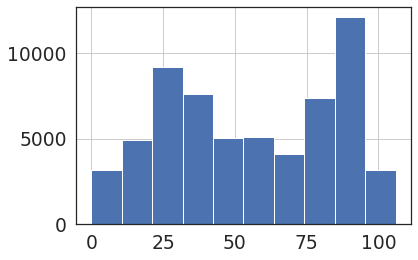

In [342]:
out_df["original_text"].map(lambda s: len(s.split()) if isinstance(s, str) else 0).hist()

<AxesSubplot:>

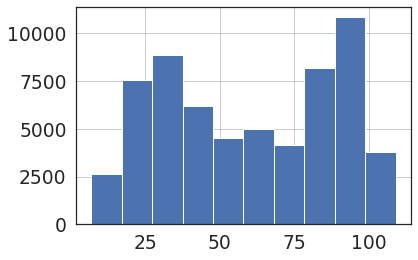

In [343]:
out_df["perturbed_text"].map(lambda s: len(s.split()) if isinstance(s, str) else 0).hist()